## **Importing libraries**

In [1]:
import io
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Reading the data**

Firstly we are going to use only the main csv which is called application for our analysis so let's start by reading training data

In [2]:
drive.mount('/content/gdrive')
root_path1 = '/content/gdrive/My Drive/Vodafone_Credit_Risk'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
os.chdir(root_path1) #change current working directory
print(os.getcwd())

/content/gdrive/My Drive/Vodafone_Credit_Risk


In [4]:
#Reading application_train
train = pd.read_csv('application_train.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train.shape

(307511, 122)

The application_train has 307511 observation with 121 features in addition to target variable

In [0]:
#Now let's read testing data

In [5]:
test = pd.read_csv('application_test.csv')
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
test.shape

(48744, 121)

Test has 48744 observations and 121 features with no target variable as expected

# **Exploratory Data Analysis** 

### **TARGET variable analysis**

First of all we will check the distribution of the target column

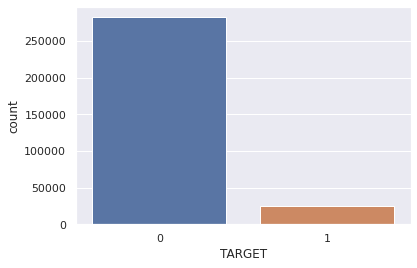

In [0]:
sns.set(style="darkgrid")
sns.countplot(x="TARGET", data=train)

There is obviuos imbalance in the target variable and this is expected becasue it is often difficult to get amount of data for clients with payment difficulties compared to the clients that paid normally so we will take this into consideration before moving to modeling part by upsampling the minority class

### **Checking column types**

In [0]:
# Number of each type of column
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

This means we have 16 categorical variables so let's check which variables and whether they are really categorical or not

In [0]:
train.select_dtypes('object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


From the above display we can confirm that all columns are really categorical but how many categories for each column? this is important because we will have to encode each column using one hot encoder before using our model which will increase variables a lot If number of categories is high

In [0]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

There are some columns with very high categories so we can first decide to work using one-hot encoder then use dimensionlaity reduction

### **Missing Values**

For the missing values we can drop the columns with very high percentage of missing values but we need to be careful as sometimes imputing the columns with missing values is better for the model compared to deleting the column

In [0]:
#We will finf the percentage of null values compared to total values for each column
train_percent = 100 * train.isnull().sum() / len(train)
#We will formulate train_percent into dataframe
train_percent = train_percent.to_frame().reset_index()
#We will rename the columns
train_percent.columns= ["Feature","Null Percentage"]
#Finally let's sort the percentage from higher to lower
train_percent.sort_values(by=['Null Percentage'],ascending=False)

,Feature,Null Percentage
76,COMMONAREA_MEDI,69.872297
48,COMMONAREA_AVG,69.872297
62,COMMONAREA_MODE,69.872297
70,NONLIVINGAPARTMENTS_MODE,69.432963
56,NONLIVINGAPARTMENTS_AVG,69.432963
...,...,...
15,NAME_HOUSING_TYPE,0.000000
14,NAME_FAMILY_STATUS,0.000000
13,NAME_EDUCATION_TYPE,0.000000
12,NAME_INCOME_TYPE,0.000000


Although null values percentage is high for some columns we can impute them rather than completely delete the columns

### **Correlations**

In order to better understand the data let's see how differnet features correlate with TARGET variable noting that having zero correlation means there is no linear relation between variables which doesn't mean that they have no realation at all as non-linear relation can be presented 

In [0]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


TARGET is highly correlated with DAYS_BIRTH(which is Client's age in days at the time of application) also with REGION_RATING_CLIENT_W_CITY(rating of the region where client lives with taking city into account) so let's check this relations

In [0]:
train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

The client age is in negative so for these situations we need to confirm what does it mean.

Next we will check REGION_RATING_CLIENT_W_CITY which is categorical variable

In [0]:
train['REGION_RATING_CLIENT_W_CITY']

0         2
1         1
2         2
3         2
4         2
         ..
307506    1
307507    2
307508    3
307509    2
307510    1
Name: REGION_RATING_CLIENT_W_CITY, Length: 307511, dtype: int64

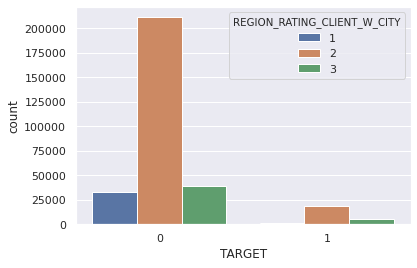

In [0]:
sns.set(style="darkgrid")
sns.countplot(x="TARGET",hue="REGION_RATING_CLIENT_W_CITY", data=train) 

It is obvious from the above graph that almost all clients in region 1 has no difficulties in payment.

# **Data Preprocessing** 

### **One-hot Encoding**

We will apply one hot encoding for both training and testing data noting that we've to take into consideration that maybe some columns are represented in the training data only so we've to remove them

In [14]:
# one-hot encoding of categorical variables
train_encoded = pd.get_dummies(train)
test_encoded = pd.get_dummies(test)

print('Training Features shape: ', train_encoded.shape)
print('Testing Features shape: ', test_encoded.shape)

Training Features shape:  (307511, 246)
Testing Features shape:  (48744, 242)


Now we will remove the columns in training data which are not presented in test data except for TARGET

In [15]:
#We will extract labels in different dataframe
labels = train_encoded['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train_encoded, test_encoded = train_encoded.align(test_encoded, join = 'inner', axis = 1)

print('Training Features shape: ', train_encoded.shape)
print('Testing Features shape: ', test_encoded.shape)

Training Features shape:  (307511, 242)
Testing Features shape:  (48744, 242)


### **Imputation and Scaling**

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train_encoded)

# Transform both training and testing data
train_imputed = imputer.transform(train_encoded)
test_imputed = imputer.transform(test_encoded)

# Repeat with the scaler
scaler.fit(train_encoded)
train_scaled = scaler.transform(train_imputed)
test_scaled = scaler.transform(test_imputed)

print('Training data shape: ', train_scaled.shape)
print('Testing data shape: ', test_scaled.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 242)


In the above code we did 2 crucial preprocessing steps the first is to impute the null values and we selected to impute with median values for each column then scaling which will force all features to have the same range of values as having wide range of values will affect the perfromance for most of the algorithms

# **Model Selection** 

For simplicity we will start for logistic regression in order to solve this classification problem then we will try to fine-tune its parameters and use other algorithms specially ensemble ones 

### **Baseline - Logistic Regression**

As we saw in the EDA part the data is highly imbalanced and we will use SMOTE to upsample the minority but let's first try logisitc regression without upsampling 

In [0]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.001)

# Train on the training data
log_reg.fit(train_scaled, labels)

# We need the probability and not the prediction itself so we will record the result of predict_proba
log_reg_pred = log_reg.predict_proba(test_scaled)[:, 1]

In [0]:
#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
log_reg_baseline = test[['SK_ID_CURR']]
log_reg_baseline['TARGET'] = log_reg_pred

log_reg_baseline.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SK_ID_CURR,TARGET
0,100001,0.057600
1,100005,0.187673
2,100013,0.042583
3,100028,0.057517
4,100038,0.131593


Finally we will save the dataframe as CSV and submit on Kaggle

In [0]:
log_reg_baseline.to_csv('log_reg_baseline.csv', index = False)

We got score of 0.72066 which is not bad for baseline value

### **Logistic Regression + PCA**

Now we will try Logistic Regression again but after doing dimensionality reduction and we will use cross validation to get the best result

In [0]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe_logreg = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64, 75, 100],
    'logistic__C': [0.001,0.0001],
}

#We will make 5-folds cross validation and we will choose scoring metric as roc_auc instead of accuracy
search = GridSearchCV(pipe_logreg, param_grid, scoring='roc_auc', cv=5)

best_acc = search.fit(train_scaled, labels)

In [0]:
#Little inrease compared to model without dimensionality reduction
best_acc.best_score_

0.7293114013360792

Let's save the prediction probability and submit again

In [0]:
log_PCA_pred = search.predict_proba(test_scaled)[:, 1]

In [0]:
#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
log_PCA_baseline = test[['SK_ID_CURR']]
log_PCA_baseline['TARGET'] = log_PCA_pred

log_PCA_baseline.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SK_ID_CURR,TARGET
0,100001,0.058012
1,100005,0.182719
2,100013,0.040257
3,100028,0.057302
4,100038,0.131720


In [0]:
log_PCA_baseline.to_csv('log_PCA_baseline.csv', index = False)

Score is lower than the baseline which shows that reducing the feature to only 100 components didn't help

### **Logistic Regression + PCA + SMOTE**

During EDA phase we knew that the data is highly imbalanced so we will use SMOTE to balance the data first 

In [0]:
#Now let's move to upsamling step
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(labels==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(labels==0)))

sm = SMOTE(random_state=42)
train_scaled_res, labels_res = sm.fit_sample(train_scaled, labels.ravel())

print('After OverSampling, the shape of train_X: {}'.format(train_scaled_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(labels_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(labels_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(labels_res==0)))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Before OverSampling, counts of label '1': 24825
Before OverSampling, counts of label '0': 282686 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (565372, 242)
After OverSampling, the shape of train_y: (565372,) 

After OverSampling, counts of label '1': 282686
After OverSampling, counts of label '0': 282686


Now we will use logistic regression again with PCA but we will not decrease number of components in PCA

In [0]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA()
logistic = LogisticRegression(max_iter=10000)
pipe_logPCA = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [50,100,150,200,240],
    'logistic__C': [0.001,0.0001],
}

#We will make 5-folds cross validation and we will choose scoring metric as roc_auc instead of accuracy
search = GridSearchCV(pipe_logreg, param_grid, scoring='roc_auc', cv=5)

search.fit(train_scaled_res, labels_res)
search.best_score_

0.6874428901453978

As we can see upsampling didn't help

### **Naive Bayes**

In [0]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(train_scaled, labels)

nb_predict=nb.predict_proba(test_scaled)[:, 1]

In [11]:
#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
nb_baseline = test[['SK_ID_CURR']]
nb_baseline['TARGET'] = nb_predict

nb_baseline.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SK_ID_CURR,TARGET
0,100001,0.037393
1,100005,0.366989
2,100013,0.152249
3,100028,0.030801
4,100038,0.293269


In [0]:
nb_baseline.to_csv('nb_baseline.csv', index = False)

We got a score of around 0.63 which is way less than baseline which is somehow expected as naive bayes usually work better for text classification and needs independent features which is not our case

### **Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=0)

# Train on the training data
rf.fit(train_scaled, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
# We need the probability and not the prediction itself so we will record the result of predict_proba
rf_pred = rf.predict_proba(test_scaled)[:, 1]

#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
rf_200 = test[['SK_ID_CURR']]
rf_200['TARGET'] = rf_pred

rf_200.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,SK_ID_CURR,TARGET
0,100001,0.085
1,100005,0.140
2,100013,0.080
3,100028,0.055
4,100038,0.145


In [0]:
rf_100.to_csv('rf_200.csv', index = False)

After submission we found score is less than logisitc regression(0.70)

### **XGBOOST**

In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
 
# fit the model with the training data
xgb.fit(train_scaled, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# We need the probability and not the prediction itself so we will record the result of predict_proba
xgb_pred = xgb.predict_proba(test_scaled)[:, 1]

#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
xgb_baseline = test[['SK_ID_CURR']]
xgb_baseline['TARGET'] = xgb_pred

xgb_baseline.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,SK_ID_CURR,TARGET
0,100001,0.058895
1,100005,0.113352
2,100013,0.024959
3,100028,0.041916
4,100038,0.128910


In [0]:
xgb_baseline.to_csv('xgb.csv', index = False)

XGBOOST model shows good improvement socre is around 0.738 so we will make some hyperparameter tuning

### **XGBOOST tuning**

Here we will not use Gridsearch as we need to invovle many hyperparamaters so RandomizedSearch will be used.

In [0]:

from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc',cv=skf.split(train_scaled, labels), verbose=3, random_state=1001 )

# Now let's start
random_search.fit(train_scaled, labels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] min_child_weight=1, max_depth=5, gamma=1 ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=1, max_depth=5, gamma=1, score=0.752, total=16.4min
[CV] min_child_weight=1, max_depth=5, gamma=1 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.4min remaining:    0.0s


[CV]  min_child_weight=1, max_depth=5, gamma=1, score=0.756, total=16.5min
[CV] min_child_weight=1, max_depth=5, gamma=1 ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 33.0min remaining:    0.0s


[CV]  min_child_weight=1, max_depth=5, gamma=1, score=0.759, total=16.6min
[CV] min_child_weight=5, max_depth=3, gamma=5 ........................
[CV]  min_child_weight=5, max_depth=3, gamma=5, score=0.749, total=10.2min
[CV] min_child_weight=5, max_depth=3, gamma=5 ........................
[CV]  min_child_weight=5, max_depth=3, gamma=5, score=0.752, total=10.2min
[CV] min_child_weight=5, max_depth=3, gamma=5 ........................
[CV]  min_child_weight=5, max_depth=3, gamma=5, score=0.755, total=10.3min
[CV] min_child_weight=5, max_depth=3, gamma=1 ........................
[CV]  min_child_weight=5, max_depth=3, gamma=1, score=0.749, total=10.3min
[CV] min_child_weight=5, max_depth=3, gamma=1 ........................
[CV]  min_child_weight=5, max_depth=3, gamma=1, score=0.752, total=10.2min
[CV] min_child_weight=5, max_depth=3, gamma=1 ........................
[CV]  min_child_weight=5, max_depth=3, gamma=1, score=0.755, total=10.5min
[CV] min_child_weight=10, max_depth=3, gamma=1 ..

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 173.5min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f879db2ce08>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
              

In [0]:
random_search.best_params_

{'gamma': 1, 'max_depth': 5, 'min_child_weight': 1}

In [0]:
xgb_pred = random_search.predict_proba(test_scaled)[:, 1]

#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
xgb_tuned = test[['SK_ID_CURR']]
xgb_tuned['TARGET'] = xgb_pred

xgb_tuned.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,SK_ID_CURR,TARGET
0,100001,0.037501
1,100005,0.112116
2,100013,0.021225
3,100028,0.035957
4,100038,0.136407


In [0]:
xgb_tuned.to_csv('xgb_tuned.csv', index = False)

We got score of 0.744 which is better than all other algortihms

### **XGBOOST tuning without null previous imputation**

One of the most powerful features of XGBOOST is its ability to fill null values so we will use training data directly before filling the nulls with median. Filling the null values with median isn't very good idea specially with categorical features.

In [23]:
#We will got the data after one-hot encoding and directly apply scaling 
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train_encoded)
train_scaled = scaler.transform(train_encoded)
test_scaled = scaler.transform(test_encoded)

from xgboost import XGBClassifier
xgb = XGBClassifier(gamma=1,max_depth=5,learning_rate=0.02, n_estimators=600)
 
# fit the model with the training data
xgb.fit(train_scaled, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
# We need the probability and not the prediction itself so we will record the result of predict_proba
xgb_pred = xgb.predict_proba(test_scaled)[:, 1]

#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
xgb_impute = test[['SK_ID_CURR']]
xgb_impute['TARGET'] = xgb_pred

xgb_impute.head()

xgb_impute.to_csv('xgb_tuned.csv', index = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Imputation with mediana and letting XGBOOST to impute didn't show great differnece although some addtional hyperparameter tuning can affect the model with no ipmutation.

### **LightGBM tuning without null previous imputation**

In [32]:
import lightgbm

#These parameters are for the 7th in this competition and of course it will not be the best for me for differnet feature selection and preprocessing 
#If the best for my features is needed autoML library can be used for example to output the best parameters
parameters = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

train_data = lightgbm.Dataset(train_scaled, label=labels)

lgbm = lightgbm.train(parameters,
                       train_data,
                       num_boost_round=5000,
                       )

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [33]:
# We need the probability and not the prediction itself so we will record the result of predict_proba
lgbm_pred = lgbm.predict(test_scaled)

#Now we will prepare for submission by having dataframe that includes 2 columns SK_ID_CURR and TARGET
lgbm_baseline = test[['SK_ID_CURR']]
lgbm_baseline['TARGET'] = lgbm_pred

lgbm_baseline.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,SK_ID_CURR,TARGET
0,100001,0.012903
1,100005,0.113357
2,100013,0.036941
3,100028,0.029693
4,100038,0.124116


In [0]:
lgbm_baseline.to_csv('lgbm_tuned.csv', index = False)

score of around 0.724 which doesn't beat XGBOOST

### **Conclusion**

1. Tuned XGBOOST scored the best results 0.74375
2. Using more data from the other sources would definitely enhance the final score.
3. Using DNN would help but after some readings regarding this competiton tuned LightGBM and XGBOOST worked the best.